# TP2 : Classification using Linear & Quadratic Discriminant Analysis

Students:
1. Antonin Morel
2. Benjamin Renoux

In [121]:
import csv
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

## Introduction

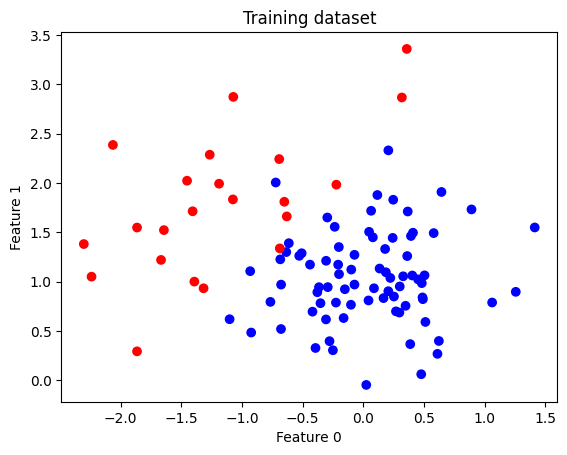

In [122]:
train = np.loadtxt('synth_train.txt')
test = np.loadtxt('synth_test.txt')

X_train = train[:, 1:]
y_train = train[:, 0]

X_test = test[:, 1:]
y_test = test[:, 0]

# Plot train dataset
plt.scatter(X_train[:,0],X_train[:,1], c= (['r' if k == 1 else 'b' for k in y_train]))
plt.title('Training dataset')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

## 1. Estimators

In [123]:
## Creation of the model
N, D = X_train.shape
classes=[1,2]
K = len(classes)
cards = []
means = []
empirical_covs = []
covariance_LDA = None
covariances_QDA = []
weights = []

# We compute the values of our estimators
for k in range(K):
    X_train_k = X_train[y_train == classes[k]]
    cards.append(X_train_k.shape[0])
    means.append( (1/cards[k]) *  np.sum(X_train_k, axis=0))
    empirical_covs.append( np.sum([np.dot((Xn - means[k]).reshape(len(Xn),1),(Xn - means[k]).reshape(len(Xn),1).T) for Xn in X_train_k], axis=0) )
    covariances_QDA.append( (1/cards[k]) * empirical_covs[k] )
    weights.append( cards[k] / N )

covariance_LDA = (1/N) * np.sum(empirical_covs, axis=0)

## Calcul of the log probabilities

In [124]:
# During the calculation process of the log probabilities, we intentionnally forget 
# the CSTE term which is the same for each P(x|y=k) for a chosen x.
# It will then have no incident during the comparison process of the log probabilities
# for different classes for a chosen x.
def log_probabilities(discriminant, x, weights, means, covariance_LDA = None, covariances_QDA = None):
    assert (discriminant == "quadratic" or discriminant == "linear"), "Discriminant type unvalid"
    if discriminant == "quadratic":
        return np.array( [(-1/2)* (x-means[k]).T @ la.inv(covariances_QDA[k]) @ (x-means[k]) + np.log(weights[k]) - (1/2)*np.log(la.det(covariances_QDA[k])) for k in range(K)] )
    elif discriminant == "linear":
        return np.array([ x @ la.inv(covariance_LDA) @ means[k] + np.log(weights[k]) - (1/2)* means[k].T @ la.inv(covariance_LDA) @ means[k] for k in range(K)])


## Calcul of the prediction classes

In [125]:
# We create a function to calculate the prediction classes for a set of points
def predict_class(X, discriminant):
    if discriminant == "quadratic":
        X_train_quadratic_log_probabilities = np.array([log_probabilities("quadratic", x, weights, means, covariances_QDA=covariances_QDA) for x in X])
        return np.array([ classes[np.argmax(x)] for x in X_train_quadratic_log_probabilities])
    else: 
        X_train_linear_log_probabilities = np.array([log_probabilities("linear", x, weights, means, covariance_LDA=covariance_LDA) for x in X])
        return np.array([ classes[np.argmax(x)] for x in X_train_linear_log_probabilities])

y_train_quadratic_pred = predict_class(X_train,"quadratic")
y_train_linear_pred = predict_class(X_train,"linear")
y_test_quadratic_pred = predict_class(X_test,"quadratic")
y_test_linear_pred = predict_class(X_test,"linear")

## Display of the prediction results and the error rates

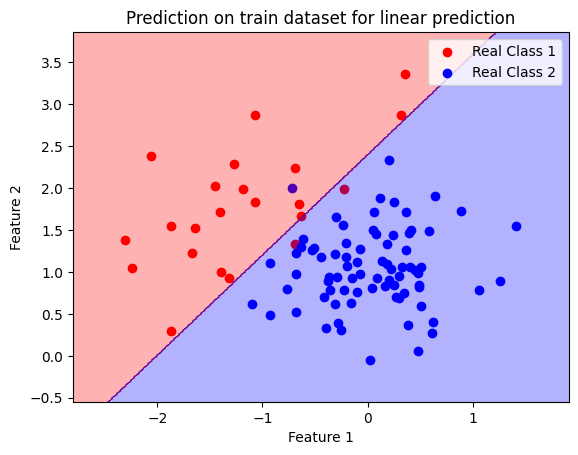

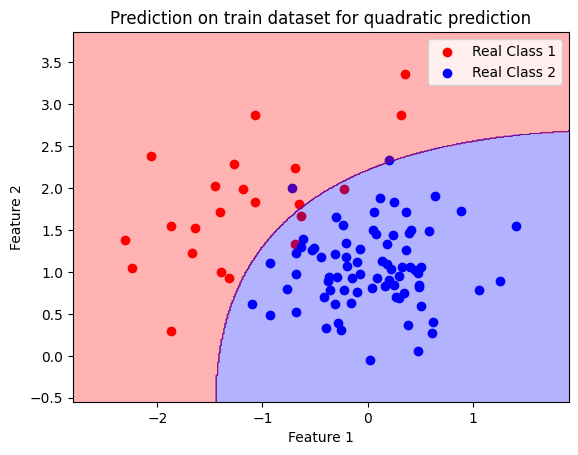

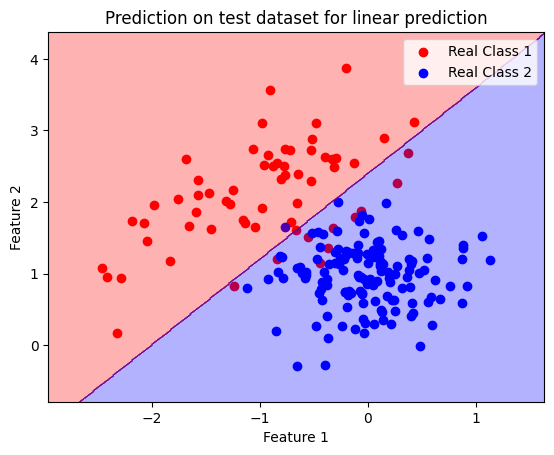

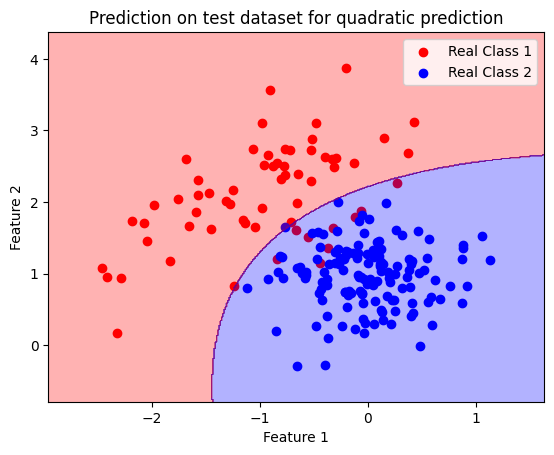

Linear Discriminant Analysis :


    Error on training dataset : 3.0%
    Error on test dataset : 5.5%


Quadratic discriminant analysis :


    Error on training dataset : 5.0%
    Error on test dataset : 5.0%


In [126]:

def plot_prediction(X, y_real, discriminant, set):
    # We plot the predicted classes for set of points
    plt.scatter(X[y_real == classes[0], 0],X[y_real == classes[0], 1], c='r', label=f"Real Class {classes[0]}")
    plt.scatter(X[y_real == classes[1], 0],X[y_real == classes[1], 1], c='b', label=f"Real Class {classes[1]}")
    plt.title(f'Prediction on {set} dataset for {discriminant} prediction')
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # We plot the regions
    Nx1 = 400
    Nx2 = 400
    x1 = np.linspace(min(X[:,0])-0.5, max(X[:,0])+0.5, Nx1)
    x2 = np.linspace(min(X[:,1])-0.5, max(X[:,1])+0.5, Nx2)
    X1, X2 = np.meshgrid(x1,x2)
    coordinates = np.column_stack((X1.ravel(), X2.ravel()))
    Z = predict_class(coordinates, discriminant).reshape(X1.shape)
    plt.contourf(X1, X2, Z, alpha=0.3, colors=['red', 'blue'])
    plt.show()

plot_prediction(X_train, y_train, "linear", "train")
plot_prediction(X_train, y_train, "quadratic", "train")
plot_prediction(X_test, y_test, "linear", "test")
plot_prediction(X_test, y_test, "quadratic", "test")

# We calculate the error
def calculate_error(y_predicted, y_real):
    differences = np.sum(y_predicted != y_real)
    return (differences / len(y_predicted)) * 100

print('Linear Discriminant Analysis :')
print('\n')
print(f'    Error on training dataset : {calculate_error(y_train_linear_pred, y_train)}%')
print(f'    Error on test dataset : {calculate_error(y_test_linear_pred, y_test)}%')
print('\n')
print('Quadratic discriminant analysis :')
print('\n')
print(f'    Error on training dataset : {calculate_error(y_train_quadratic_pred, y_train)}%')
print(f'    Error on test dataset : {calculate_error(y_test_quadratic_pred, y_test)}%')

## Comments

### Comparison between our implementation of LDA & QDA

There is no big difference between both errors. However, the region drawn by the QDA algorithm seems to fit more the scatter plot. We might lack of data to observe a relevant difference.


### Comparison with KNN algorithm


In [127]:
from sklearn.neighbors import KNeighborsClassifier

In [128]:
k = 2
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(X_train, y_train)
y_knn_pred_train = knn.predict(X_train)
y_knn_pred_test = knn.predict(X_test)

print('K-NN Algorithm :')
print('\n')
print(f'    Error on training dataset : {calculate_error(y_knn_pred_train, y_train)}%')
print(f'    Error on test dataset : {calculate_error(y_knn_pred_test, y_test)}%')

K-NN Algorithm :


    Error on training dataset : 3.0%
    Error on test dataset : 6.0%


We observe that the error rate is nearly the same between the two approaches.
The LDA & QDA algorithm however seem to be slightly more performant on the test dataset and may feat with more accuracy the dataset distribution.

### Comparison with Scikit LDA & QDA implementation

In [129]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train, y_train)
y_sk_lda_pred_train = lda.predict(X_train)
y_sk_lda_pred_test = lda.predict(X_test)



qda.fit(X_train, y_train)
y_sk_qda_pred_train = qda.predict(X_train)
y_sk_qda_pred_test = qda.predict(X_test)

print('SK-learn LDA :')
print('\n')
print(f'    Error on training dataset : {calculate_error(y_sk_lda_pred_train, y_train)}%')
print(f'    Error on test dataset : {calculate_error(y_sk_lda_pred_test, y_test)}%')
print('\n')
print('SK-learn QDA :')
print('\n')
print(f'    Error on training dataset : {calculate_error(y_sk_qda_pred_train, y_train)}%')
print(f'    Error on test dataset : {calculate_error(y_sk_qda_pred_test, y_test)}%')

SK-learn LDA :


    Error on training dataset : 3.0%
    Error on test dataset : 5.5%


SK-learn QDA :


    Error on training dataset : 5.0%
    Error on test dataset : 5.0%


We observe that the error rate of sklearn LDA & QDA implementation is exactly the same that the one we obtain with our implementation. It is normal as we use the same process to calculate the estimators (cf the documentation). 